# 02: Usage example - Traveling Salesperson Problem (TSP)

In this example, the quasar solver is applied to a complex, real-world combinatorial optimization problem: the **Traveling Salesperson Problem (TSP)**. We'll use `pyqubo` as a standardized qubo-creation tool.

The TSP includes hard constraints, creating a challenging energy landscape. This makes it an excellent benchmark for visualizing the two-phase nature of a complex simulated annealing run:

1.  **Constraint Satisfaction:** The solver first works to find any valid tour, often remaining at a high energy.
2.  **Optimization:** Once a valid tour is found, the solver refines the path to find the shortest possible distance.

In [1]:
%matplotlib inline
import numpy as np

# Import our solver components and plotting utilities
from quasar_solver import QUBO, Solver
from quasar_solver.utils import ModelConverter

# pyqubo for building the QUBO model symbolically
from pyqubo import Array, Constraint, Placeholder

# plotting utilities
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

print("Setup complete.")

Setup complete.


## 1. Modelling the Traveling Salesperson Problem (TSP) with pyqubo

The **Traveling Salesperson Problem (TSP)** is a well-known optimization challenge: find the shortest possible route that visits a set of cities exactly once and returns to the origin. In this example, we will solve the TSP for 12 European cities: Berlin, Paris, Rome, Madrid, London, Vienna, Warsaw, Stockholm, Lisbon, Athens, Amsterdam, and Prague.

To solve this with the quasar solver, we must express both the goal (minimize distance) and the the constraints as a single quadratic equation, called a Hamiltonian ($H$).

The total Hamiltonian is a sum of an objective term and two constraint penalty terms:
$$H = H_{A} + H_{B}$$

### Decision Variables
We define a binary variable $x_{i,p}$ which equals **1** if the route visits **city $i$** at **position $p$** in the tour, and **0** otherwise. For 12 cities, this gives us $12 \times 12 = 144$ variables. More generally, for $n$ cities, we have $n \times n = n^2$ variables. 

### A: The Objective Term (Distance)
This term represents the total distance of the tour. We sum the distances $d_{i,j}$ between every pair of cities $(i, j)$ that are visited consecutively in the tour (at steps $p$ and $p+1$).
$$ H_{A} = \sum_{p=0}^{N-1} \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} d_{ij} \cdot x_{i,p} \cdot x_{j, p+1} $$

### B: The Constraint Terms (Penalties)
These terms enforce the constraints of the problem. If a constraint is broken, a large penalty value is added to the energy, making that solution unfavorable. 
1.  **Each city must be visited exactly once:** For each city $i$, the sum of its variables over all positions $p$ must equal 1.
    $$ H_{B1} = P \cdot \sum_{i=0}^{N-1} \left(1 - \sum_{p=0}^{N-1} x_{i,p}\right)^2 $$
2.  **Each tour position must be filled exactly once:** For each position $p$, the sum of its variables over all cities $i$ must equal 1.
    $$ H_{B2} = P \cdot \sum_{p=0}^{N-1} \left(1 - \sum_{i=0}^{N-1} x_{i,p}\right)^2 $$

QUBO problems, which we are using as input for our simulated annealing solver, are unconstrained (Quadratic **Unconstrained** Binary Optimization). In constrast to other optimization models, we are therefore unable to enforce fixed constraints. Instead, we must use a penalty term to enforce them. The penalty constant $P$ must be large enough to ensure that any invalid tour has a higher energy than any valid tour.

Instead of manually calculating the complex $144 \times 144$ Q matrix from this Hamiltonian, we will use **`pyqubo`**. It's a Python library that allows us to define the Hamiltonian symbolically, almost exactly as we wrote it mathematically above. `pyqubo` then handles the difficult work of compiling this symbolic expression into the final numerical QUBO for our solver.

In [2]:
# --- 1. Problem Definition ---
cities = ['Berlin', 'Paris', 'Rome', 'Madrid', 'London', 'Vienna', 'Warsaw', 'Stockholm', 'Lisbon', 'Athens', 'Amsterdam', 'Prague']
n_cities = len(cities)

# Coordinates for plotting the map (Latitude, Longitude)
coords = {'Berlin': (52.52, 13.405), 
          'Paris': (48.8566, 2.3522), 
          'Rome': (41.9028, 12.4964), 
          'Madrid': (40.4168, -3.7038), 
          'London': (51.5074, -0.1278), 
          'Vienna': (48.2082, 16.3738), 
          'Warsaw': (52.2297, 21.0122), 
          'Stockholm': (59.3293, 18.0686), 
          'Lisbon': (38.7223, -9.1393), 
          'Athens': (37.9838, 23.7275), 
          'Amsterdam': (52.3676, 4.9041), 
          'Prague': (50.0755, 14.4378)}
city_coords_array = np.array([coords[city] for city in cities])

# Distances of the 12 cities to one another
dist_matrix = np.array([
    [0,     877,    1181,   1869,   931,    523,    517,    810,    2312,   1802,   576,    281], 
    [877,   0,      1105,   1052,   343,    1033,   1366,   1543,   1452,   2095,   429,    882], 
    [1181,  1105,   0,      1364,   1433,   764,    1314,   1975,   1863,   1050,   1295,   920], 
    [1869,  1052,   1364,   0,      1263,   1809,   2289,   2593,   502,    2369,   1481,   1772], 
    [931,   343,    1433,   1263,   0,      1235,   1448,   1432,   1584,   2391,   357,    1034], 
    [523,   1033,   764,    1809,   1235,   0,      555,    1241,   2298,   1282,   935,    250], 
    [517,   1366,   1314,   2289,   1448,   555,    0,      810,    2759,   1598,   1093,   517], 
    [810,   1543,   1975,   2593,   1432,   1241,   810,    0,      2759,   1598,   1093,   517], 
    [2312,  1452,   1863,   502,    1584,   2298,   2759,   2988,   0,      2851,   1863,   2243], 
    [1802,  2095,   1050,   2369,   2391,   1282,   1598,   2407,   2851,   0,      2163,   1533], 
    [576,   429,    1295,   1481,   357,    935,    1093,   1125,   1863,   2163,   0,      710], 
    [281,   882,    920,    1772,   1034,   250,    517,    1054,   2243,   1533,   710,    0]
])

# --- 2. Define pyqubo Variables and Hamiltonian ---
x = Array.create('x', (n_cities, n_cities), 'BINARY')
objective_func = 0
for i in range(n_cities):
    for j in range(n_cities):
        for p in range(n_cities):
            objective_func += dist_matrix[i, j] * x[i, p] * x[j, (p + 1) % n_cities]

P = Placeholder('penalty_weight')
constraint_city = sum(Constraint((sum(x[i, p] for p in range(n_cities)) - 1)**2, label=f'city_{i}') for i in range(n_cities))
constraint_step = sum(Constraint((sum(x[i, p] for i in range(n_cities)) - 1)**2, label=f'step_{p}') for p in range(n_cities))
H = objective_func + P * (constraint_city + constraint_step)

# --- 3. Compile pyqubo model ---
model = H.compile()
feed_dict = {'penalty_weight': 1.5 * np.mean(dist_matrix)}

print(f'PyQubo model created successfully with {n_cities} cities.')

PyQubo model created successfully with 12 cities.


While pyqubo models offer a great standardized way to build QUBOs based on symbolic expressions and to analyze results, it's dictionary-based interface is not directly compatible with the Quasar Solver's NumPy-based engine. To make use of pyqubos benefits while using the Numpy-based engine, we provide a ModelConverter utility class that allows easy conversion. 

In [3]:
# Using ModelCoverter to to get Quasar-ready numpy matrix
Q, offset, labels = ModelConverter.from_pyqubo(model, feed_dict)
problem = QUBO(Q)

print(f"Matrix generated with shape: {Q.shape}")

Matrix generated with shape: (144, 144)


For a more intuitive understanding of the problem, we'll create a plotting function that shows the cities and the tour at a later stage. 

Map of the cities to be visited:


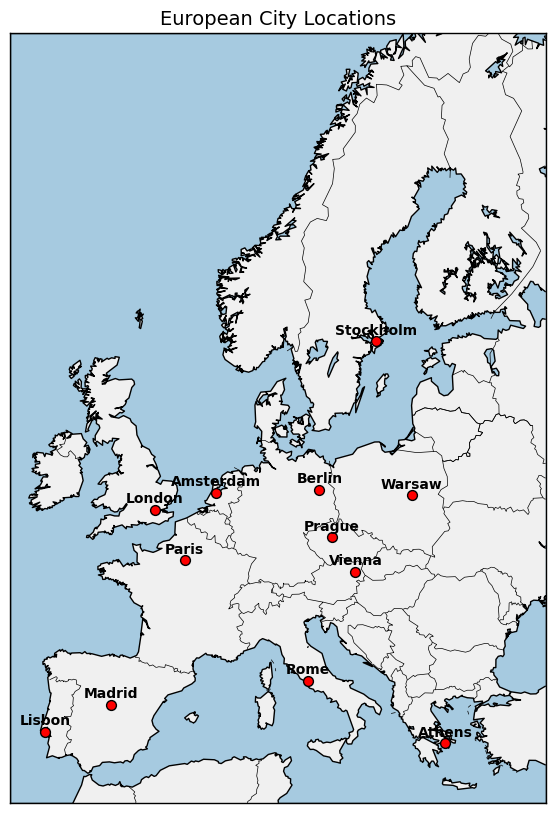

In [4]:
def plot_tour(coordinates_dict, city_names, path=None):
    """Helper function to plot the cities and the tour path on a map of Europe."""
    plt.figure(figsize=(12, 10))
    
    # Initialize the Basemap for Europe
    m = Basemap(projection='merc', llcrnrlat=34, urcrnrlat=70, 
                llcrnrlon=-12, urcrnrlon=32, lat_ts=50, resolution='l')
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='#A6CAE0')
    m.fillcontinents(color='#f0f0f0', lake_color='#A6CAE0')
    
    # Convert lat/lon to map projection coordinates
    lats = [coordinates_dict[city][0] for city in city_names]
    lons = [coordinates_dict[city][1] for city in city_names]
    x, y = m(lons, lats)
    
    # Plot cities
    m.scatter(x, y, s=50, c='red', zorder=5, edgecolors='black')
    
    for i, city in enumerate(city_names):
        plt.text(x[i], y[i] + 40000, city, ha='center', fontsize=10, fontweight='bold', zorder=6)
    
    # Plot the tour path if a solution is provided
    if path:
        path_full = path + [path[0]] # Close the loop
        for i in range(len(path_full) - 1):
            start_node = path_full[i]
            end_node = path_full[i+1]
            
            # Draw great circles for the path
            m.drawgreatcircle(lons[start_node], lats[start_node], 
                             lons[end_node], lats[end_node], 
                             linewidth=2, color='red', zorder=4)
                             
        tour_str = ' -> '.join([city_names[i] for i in path_full])
        plt.title(f'TSP Solution Path\n{tour_str}', fontsize=14)
    else:
        plt.title('European City Locations', fontsize=14)
    
    plt.show()

# --- Visualize the initial problem ---
print('Map of the cities to be visited:')
plot_tour(coords, cities)

## 2. Running the Solver

We configure the solver with the parameters explained in the basic tutorial. Note that setting a reasonable high `initial_temp`, as well as a high `iterations_per_temp`, is important for increasing the chance of finding a good solution.

In [5]:
# The initial temperature must be high enough to overcome the large penalties
solver = Solver(
    qubo=problem,
    initial_temp=50000,
    final_temp=0.1,
    iterations_per_temp=2000,
    schedule_params={'alpha': 0.999},
    track_history=False
)

result = solver.solve()

print(f'\nSolver finished.')
print(f'Lowest energy found: {result.energy}')

Annealing complete. Final energy: -35125.74999998823

Solver finished.
Lowest energy found: -35125.74999998823


Using the result object, we can make use of pyqubo's built-in decoding functionality to convert the binary solution back to the original variable names and the check for constraint violations. 
Finally, we decode the solution to get the optimal tour before plotting it.

Found a valid solution with 0 broken constraints!

Optimal path found: Stockholm -> Prague -> Vienna -> Warsaw -> Madrid -> Berlin -> Athens -> Lisbon -> Amsterdam -> Rome -> Paris -> London -> Stockholm
Total distance: 16171.00 km


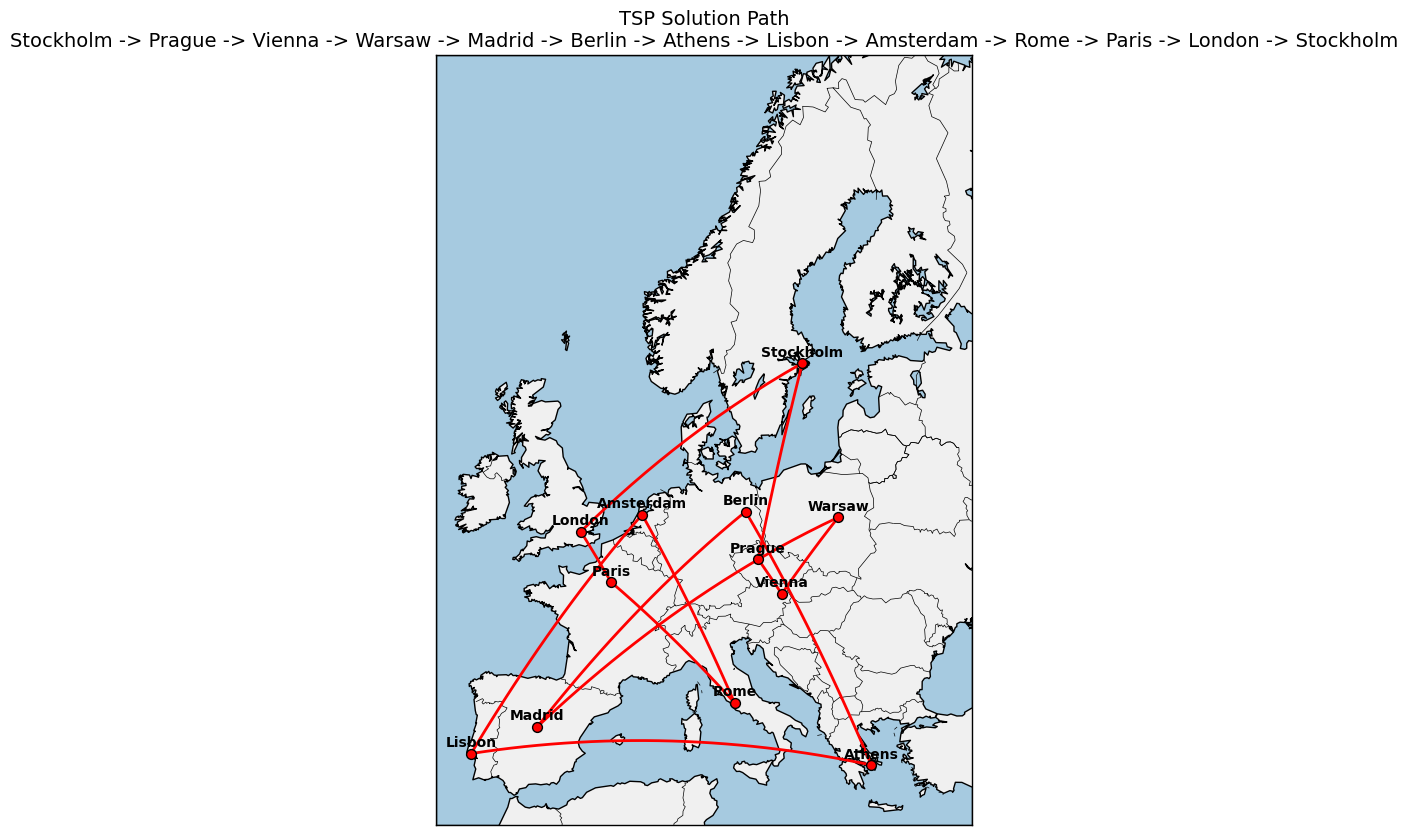

In [6]:
# Decode the solution into the pyqubo format
decoded_sample = model.decode_sample(result.state, vartype='BINARY', feed_dict=feed_dict)

# Check for broken constraints in the best solution
num_broken = len(decoded_sample.constraints(only_broken=True))

if num_broken > 0:
    print(f'Found a solution with {num_broken} broken constraints.')
    print('Try increasing the penalty_weight or running more iterations.')
    print(decoded_sample.constraints(only_broken=True))
else:
    print('Found a valid solution with 0 broken constraints!')
    
    # Reconstruct the path from the solution dictionary
    path = [-1] * n_cities
    for i in range(n_cities):
        for k in range(n_cities):
            # Check each variable x[i, k]
            if decoded_sample.sample[f'x[{i}][{k}]'] == 1:
                path[k] = i
    
    # Print the results
    path_str = ' -> '.join([cities[i] for i in path])
    print(f'\nOptimal path found: {path_str} -> {cities[path[0]]}')
    
    # Calculate total distance
    total_dist = sum(dist_matrix[path[k], path[(k + 1) % n_cities]] for k in range(n_cities))
    print(f'Total distance: {total_dist:.2f} km')
    
    # Plot the final tour on the map
    plot_tour(coords, cities, path)